In [162]:
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import geopandas as gpd

In [163]:
outsummary = pd.read_csv(os.path.join(r"\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater", "summary_results.csv"))

In [164]:
mdbboundary = gpd.read_file("Z:/Data/GIS/General/mdb_boundary.shp")

In [165]:
outsummary


,Unnamed: 0,scenarios,mean_event_length,event_frequency,5day_event_frequency,10day_event_frequency,temp_treshold,flow_percentile,flow_treshold,site,lat,lon
0,0,D,10.323938,10.000000,6.0,5.0,-100,0.99,73153.353906,422028,-29.942100,146.44310
1,1,H,6.638644,11.000000,6.0,5.0,-100,0.99,73153.353906,422028,-29.942100,146.44310
2,2,M,7.541866,10.000000,6.0,5.0,-100,0.99,73153.353906,422028,-29.942100,146.44310
3,3,W,4.671914,15.000000,8.0,4.0,-100,0.99,73153.353906,422028,-29.942100,146.44310
4,0,D,0.017148,0.000000,0.0,0.0,35,0.99,73153.353906,422028,-29.942100,146.44310
...,...,...,...,...,...,...,...,...,...,...,...,...
9235,3,W,1.000000,0.043860,0.0,0.0,35,0.01,2603.370000,409207,-35.942574,144.46466
9236,0,D,1.533333,0.131579,0.0,0.0,40,0.01,2603.370000,409207,-35.942574,144.46466
9237,1,H,NaN,0.000000,0.0,0.0,40,0.01,2603.370000,409207,-35.942574,144.46466
9238,2,M,2.500000,0.017544,0.0,0.0,40,0.01,2603.370000,409207,-35.942574,144.46466


In [166]:
unique_percentiles = outsummary['flow_percentile'].unique()
unique_temperatures = outsummary['temp_treshold'].unique()
unique_scenarios = outsummary['scenarios'].unique()
variables_to_plot = ['mean_event_length','event_frequency','5day_event_frequency']

In [181]:
for plot_variable_name in variables_to_plot: 
    for flow_percentile in unique_percentiles:
        for temp_threshold in unique_temperatures:
            outplot = outsummary[outsummary['flow_percentile']==flow_percentile]
            outplot = outplot[outplot['temp_treshold']==temp_threshold]
            outplot['scen_cat'] = outplot["scenarios"].astype('category')
            outplot["scen_cat"] = outplot["scen_cat"].cat.reorder_categories(["H", "D", "M", "W"] )

            # if 'length' in plot_variable_name and flow_percentile > 0.5:
            #     outplot[plot_variable_name] = outplot[plot_variable_name]/365.

            maxscale = outplot[plot_variable_name].max()
            nbounds = max(4,int(np.ceil( maxscale)))
            bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))

            ncolors = len(bounds) - 1

            print(nbounds, ncolors, plot_variable_name, flow_percentile,temp_threshold)
            
            cmap = plt.get_cmap('jet', ncolors)
            norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

            fig, axs = plt.subplots(2,3,figsize=(15,10) )

            fig.delaxes(axs[0,0])
            fig.delaxes(axs[0,2])


            mdbboundary.plot(color = 'None', ax = axs[0,1])
            spdata = outplot[outplot['scenarios']=="H"]
            sc = axs[0,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[0,1].set_title("Historical")

            mdbboundary.plot(color = 'None', ax = axs[1,0])
            spdata = outplot[outplot['scenarios']=="W"]
            sc = axs[1,0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[1,0].set_title("Future Wet")

            mdbboundary.plot(color = 'None', ax = axs[1,1])
            spdata = outplot[outplot['scenarios']=="M"]
            sc = axs[1,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[1,1].set_title("Future Mid")

            mdbboundary.plot(color = 'None', ax = axs[1,2])
            spdata = outplot[outplot['scenarios']=="D"]
            sc = axs[1,2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[1,2].set_title("Future Dry")

            figtitle =  "Mean event length (years)"
            if 'frequency' in plot_variable_name:
                figtitle =  "Mean event frequency (events per year)"
            elif flow_percentile < 0.5:
                figtitle =  "Mean event length (days)"

            fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = figtitle)
            fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'figure_{plot_variable_name}_{flow_percentile}_{temp_threshold}.png')
            fig.savefig(fig_path)
            plt.close(fig)

            outplot2 = outplot.copy(deep=True)
            for s in unique_scenarios:
                outplot2.loc[outplot2['scenarios']==s,plot_variable_name] = outplot.loc[outplot['scenarios']==s,plot_variable_name].values - outplot.loc[outplot['scenarios']=='H',plot_variable_name].values

            # if 'length' in plot_variable_name:
            #     outplot2[plot_variable_name] = outplot2[plot_variable_name]/365

            maxscale = outplot2[plot_variable_name].max()
            minscale = outplot2[plot_variable_name].min()

            print(minscale, maxscale)
            cmap = plt.cm.coolwarm  # define the colormap


            # define the bins and normalize
            nbounds = max(4, int(np.ceil( maxscale)))
            bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1)) #np.logspace(np.log10(1), np.log10(nbounds),num=cmap.N)
            bounds = np.concatenate((-1.0*bounds, bounds))
            bounds = np.sort(bounds)
            #norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            ncolors = len(bounds) - 1
            cmaplist = [cmap(i) for i in range(ncolors)]

            cmap = plt.get_cmap('coolwarm', ncolors)
            norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)
            #norm = plt.Normalize(0, maxscale)
            fig, axs = plt.subplots(1,3,figsize=(15,5) )

            mdbboundary.plot(color = 'None', ax = axs[0])
            # (outplot2[outplot2['scenarios']=="W"]).plot.scatter(x = 'lon', y = 'lat', c ='mean_event_length', norm = norm, cmap = cmap,ax = axs[0], legend = False)
            spdata = outplot2[outplot2['scenarios']=="W"]
            sc = axs[0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[0].set_title("Future Wet")

            mdbboundary.plot(color = 'None', ax = axs[1])
            # (outplot2[outplot2['scenarios']=="M"]).plot.scatter(x = 'lon', y = 'lat', c ='mean_event_length', norm = norm, cmap = cmap,ax = axs[1], legend = False)
            spdata = outplot2[outplot2['scenarios']=="M"]
            sc = axs[1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[1].set_title("Future Mid")

            mdbboundary.plot(color = 'None', ax = axs[2])
            spdata = outplot2[outplot2['scenarios']=="D"]
            sc = axs[2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[2].set_title("Future Dry")

            figtitle =  "Increase in mean event length (years)"
            if 'frequency' in plot_variable_name:
                figtitle =  "Increase in mean event frequency (events per year)"
            elif flow_percentile < 0.5:
                figtitle =  "Mean event length (days)"    
                
            fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = figtitle)

            fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'figure_{plot_variable_name}_{flow_percentile}_{temp_threshold}_change.png')
            fig.savefig(fig_path)
            plt.close(fig)


114 7 mean_event_length 0.99 -100
-4.669989421940141 110.57872358077697
4 2 mean_event_length 0.99 35
0.0 0.008164701322437101
4 2 mean_event_length 0.99 40
-0.0003571109722346 0.0032373743212655995
15 4 mean_event_length 0.95 -100
-1.6847660666962523 11.780568864552436
4 2 mean_event_length 0.95 35
0.0 0.0079974778478202
4 2 mean_event_length 0.95 40
-0.0003571109722346 0.003194734748555899
623 10 mean_event_length 0.1 -100
-99.2038366175127 125.12203322784808
8 3 mean_event_length 0.1 35
-1.0 2.746722200294264
4 2 mean_event_length 0.1 40
-0.5090909090909093 2.0
623 10 mean_event_length 0.05 -100
-99.2038366175127 125.12203322784808
8 3 mean_event_length 0.05 35
-0.7506097560975609 3.2747299950908197
4 2 mean_event_length 0.05 40
-0.7 2.666666666666667
623 10 mean_event_length 0.01 -100
-99.2038366175127 125.12203322784808
10 4 mean_event_length 0.01 35
-1.0178571428571432 4.174216027874564
5 3 mean_event_length 0.01 40
-1.6666666666666667 1.9516129032258065
45 6 event_frequency 0.99

In [184]:
for plot_variable_name in variables_to_plot: 
    for flow_percentile in unique_percentiles:
        for temp_threshold in unique_temperatures:
            outplot = outsummary[outsummary['flow_percentile']==flow_percentile]
            outplot = outplot[outplot['temp_treshold']==temp_threshold]
            outplot['scen_cat'] = outplot["scenarios"].astype('category')
            outplot["scen_cat"] = outplot["scen_cat"].cat.reorder_categories(["H", "D", "M", "W"] )

            # if 'length' in plot_variable_name and flow_percentile > 0.5:
            #     outplot[plot_variable_name] = outplot[plot_variable_name]/365.

            maxscale = outplot[plot_variable_name].max()
            maxscale= max(2,maxscale)
            nbounds = max(4,int(np.ceil( maxscale)))
            bounds = np.arange(0, np.ceil(maxscale))

            ncolors = len(bounds) - 1

            print(nbounds, ncolors, plot_variable_name, flow_percentile,temp_threshold)
            
            cmap = plt.get_cmap('jet', ncolors)
            norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

            # usebounds  = [0, maxscale]
                        
            #cmap = plt.get_cmap('jet') 
            #norm = mpl.colors.Normalize(usebounds[0], usebounds[1], clip = True)



            fig, axs = plt.subplots(2,3,figsize=(15,10) )

            fig.delaxes(axs[0,0])
            fig.delaxes(axs[0,2])


            mdbboundary.plot(color = 'None', ax = axs[0,1])
            spdata = outplot[outplot['scenarios']=="H"]
            sc = axs[0,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[0,1].set_title("Historical")

            mdbboundary.plot(color = 'None', ax = axs[1,0])
            spdata = outplot[outplot['scenarios']=="W"]
            sc = axs[1,0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[1,0].set_title("Future Wet")

            mdbboundary.plot(color = 'None', ax = axs[1,1])
            spdata = outplot[outplot['scenarios']=="M"]
            sc = axs[1,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[1,1].set_title("Future Mid")

            mdbboundary.plot(color = 'None', ax = axs[1,2])
            spdata = outplot[outplot['scenarios']=="D"]
            sc = axs[1,2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[1,2].set_title("Future Dry")

            figtitle =  "Mean event length (years)"
            if 'frequency' in plot_variable_name:
                figtitle =  "Mean event frequency (events per year)"
            elif flow_percentile < 0.5:
                figtitle =  "Mean event length (days)"

            fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = figtitle)
            fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'figure_{plot_variable_name}_{flow_percentile}_{temp_threshold}_linear.png')
            fig.savefig(fig_path)
            plt.close(fig)

            outplot2 = outplot.copy(deep=True)
            for s in unique_scenarios:
                outplot2.loc[outplot2['scenarios']==s,plot_variable_name] = outplot.loc[outplot['scenarios']==s,plot_variable_name].values - outplot.loc[outplot['scenarios']=='H',plot_variable_name].values

            # if 'length' in plot_variable_name:
            #     outplot2[plot_variable_name] = outplot2[plot_variable_name]/365

            maxscale = outplot2[plot_variable_name].max()
            minscale = outplot2[plot_variable_name].min()
            maxscale= max(2,maxscale)
            print(minscale, maxscale)
            cmap = plt.cm.coolwarm  # define the colormap


            # define the bins and normalize
            nbounds = max(4, int(np.ceil( maxscale)))
            bounds =  np.arange(-np.ceil(maxscale), np.ceil(maxscale)) #np.logspace(np.log10(1), np.log10(nbounds),num=cmap.N)
            # bounds = np.concatenate((-1.0*bounds, bounds))
            bounds = np.sort(bounds)
            #norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            ncolors = len(bounds) - 1
            cmaplist = [cmap(i) for i in range(ncolors)]

            cmap = plt.get_cmap('coolwarm', ncolors)
            norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)
            # #norm = plt.Normalize(0, maxscale)

            # cmap = plt.get_cmap('jet') 
            # norm = mpl.colors.Normalize(-maxscale, maxscale, clip = True)


            fig, axs = plt.subplots(1,3,figsize=(15,5) )

            mdbboundary.plot(color = 'None', ax = axs[0])
            # (outplot2[outplot2['scenarios']=="W"]).plot.scatter(x = 'lon', y = 'lat', c ='mean_event_length', norm = norm, cmap = cmap,ax = axs[0], legend = False)
            spdata = outplot2[outplot2['scenarios']=="W"]
            sc = axs[0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[0].set_title("Future Wet")

            mdbboundary.plot(color = 'None', ax = axs[1])
            # (outplot2[outplot2['scenarios']=="M"]).plot.scatter(x = 'lon', y = 'lat', c ='mean_event_length', norm = norm, cmap = cmap,ax = axs[1], legend = False)
            spdata = outplot2[outplot2['scenarios']=="M"]
            sc = axs[1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[1].set_title("Future Mid")

            mdbboundary.plot(color = 'None', ax = axs[2])
            spdata = outplot2[outplot2['scenarios']=="D"]
            sc = axs[2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
            axs[2].set_title("Future Dry")

            figtitle =  "Increase in mean event length (years)"
            if 'frequency' in plot_variable_name:
                figtitle =  "Increase in mean event frequency (events per year)"
            elif flow_percentile < 0.5:
                figtitle =  "Mean event length (days)"    
                
            fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = figtitle)

            fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'figure_{plot_variable_name}_{flow_percentile}_{temp_threshold}_change_linear.png')
            fig.savefig(fig_path)
            plt.close(fig)


114 113 mean_event_length 0.99 -100
-4.669989421940141 110.57872358077697
4 0 mean_event_length 0.99 35


ValueError: You must provide at least 2 boundaries (1 region) but you passed in array([0.])

140768 18 flow_treshold 0.05 35
140768 18 flow_treshold 0.99 35


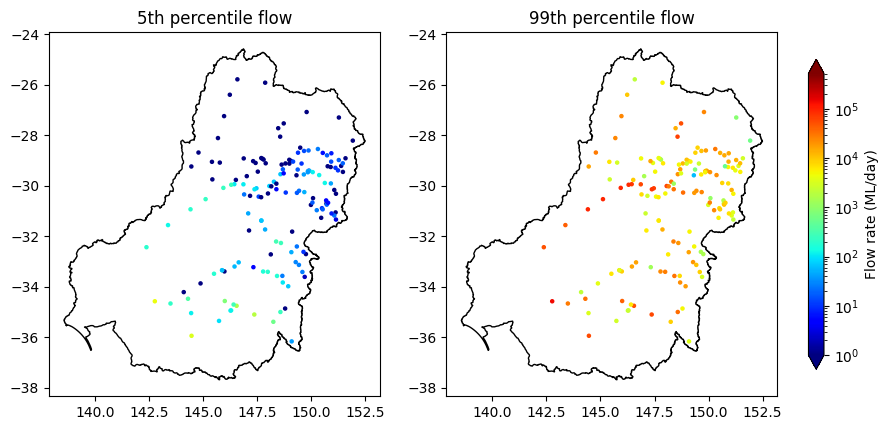

In [168]:
fig, axs = plt.subplots(1,2,figsize=(10,5) ,squeeze=False)
plot_flow_percentiles = [0.05,0.99]
plot_temperatures = [35]
plot_variable_names = ['flow_treshold']
#maxscale = outsummary[outsummary['flow_percentile'] in plot_flow_percentiles][plot_variable_name].max()

for plot_variable_name in plot_variable_names: 
    for flow_percentile in plot_flow_percentiles:
        for temp_threshold in plot_temperatures:

            outplot = outsummary[outsummary['flow_percentile']==flow_percentile]
            outplot = outplot[outplot['temp_treshold']==temp_threshold]
            outplot['scen_cat'] = outplot["scenarios"].astype('category')
            outplot["scen_cat"] = outplot["scen_cat"].cat.reorder_categories(["H", "D", "M", "W"] )

            maxscale = outsummary[plot_variable_name].max()
            minscale = outsummary[plot_variable_name].min()
            nbounds = max(4,int(np.ceil( maxscale)))
            bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))
            usebounds  = np.power(2,np.array([(np.log2(1)), np.ceil(np.log2(maxscale))+1]))
            ncolors = len(bounds) - 1

            print(nbounds, ncolors, plot_variable_name, flow_percentile,temp_threshold)
            
            cmap = plt.get_cmap('jet') #, ncolors)
            #norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)
            norm = mpl.colors.LogNorm(usebounds[0], usebounds[1], clip = True)

            plti = np.where(np.array(plot_flow_percentiles) == flow_percentile)[0][0]

            mdbboundary.plot(color = 'None', ax = axs[0,plti])
            spdata = outplot[outplot['scenarios']=="W"]
            spdata.loc[spdata['flow_treshold']<=0.1,'flow_treshold'] =0.1
            sc = axs[0,plti].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap, s = 5)
            axs[0,plti].set_title(f'{int(flow_percentile*100)}th percentile flow')
            #fig.colorbar(sc,ax=axs[0,plti],orientation='vertical', fraction=0.02, pad=0.04)
figtitle = "Flow rate (ML/day)"
fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = figtitle, extend = 'both')
fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'station_flow_percentiles.png')
fig.savefig(fig_path,bbox_inches='tight')


In [169]:
[np.floor(np.log2(minscale)), np.ceil(np.log2(nbounds))+1]

C:\Users\rob635\AppData\Local\Temp\2\ipykernel_9776\2287103030.py:1: RuntimeWarning: divide by zero encountered in log2
  [np.floor(np.log2(minscale)), np.ceil(np.log2(nbounds))+1]


[-inf, 19.0]

In [170]:
spdata


,Unnamed: 0,scenarios,mean_event_length,event_frequency,5day_event_frequency,10day_event_frequency,temp_treshold,flow_percentile,flow_treshold,site,lat,lon,scen_cat
7,3,W,0.015441,0.0,0.0,0.0,35,0.99,73153.353906,422028,-29.942100,146.443100,W
67,3,W,0.014526,0.0,0.0,0.0,35,0.99,65213.822148,422026,-30.104036,147.466436,W
127,3,W,0.014987,0.0,0.0,0.0,35,0.99,58263.769922,422002,-29.947167,146.863717,W
187,3,W,0.014421,0.0,0.0,0.0,35,0.99,66065.211406,422001,-30.015317,148.060750,W
247,3,W,0.014546,0.0,0.0,0.0,35,0.99,74952.303359,422027,-30.143433,147.376867,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947,3,W,0.016054,0.0,0.0,0.0,35,0.99,4758.434551,422502A,-28.922556,146.877750,W
9007,3,W,0.006419,0.0,0.0,0.0,35,0.99,5026.193921,410176,-34.863300,148.793100,W
9067,3,W,0.010394,0.0,0.0,0.0,35,0.99,50946.090000,425012,-32.436840,142.380230,W
9127,3,W,0.007481,0.0,0.0,0.0,35,0.99,140767.540000,414203,-34.576700,142.767500,W


In [171]:
infile_hist = xr.open_dataset("//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0H000_flow.nc")
infile_histemp = xr.open_dataset(r"\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\test_silo_sfi_drill_max_temp.nc")

parentdire = '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/'
filelist = os.listdir('//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/')
filelist = [file for file in filelist if '.nc' in file]
filelist = [parentdire + file for file in filelist if '_P0' in file]

infiles = xr.open_mfdataset(filelist, combine = 'nested', concat_dim= 'scenario')

scenarios = [file.split('0')[1] for file in filelist]
scenarios

infiles = infiles.assign_coords({'scenario' :scenarios})

sites_to_use = np.where(np.isfinite(infile_hist['flow']).all(dim = "time"))

In [172]:
sites_to_use

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  25,  26,  27,  28,
         29,  30,  35,  36,  37,  38,  39,  42,  43,  44,  45,  46,  47,
         48,  50,  52,  54,  55,  56,  57,  58,  59,  60,  61,  65,  66,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 136, 137, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170,
        171, 172, 173, 176, 185, 186, 187, 190, 194, 195, 196, 197, 199,
        200, 201, 202, 204, 205, 207, 209, 210, 211, 212, 213], dtype=int64),)

In [173]:
infile_hist['station_no'][sites_to_use]

<xarray.DataArray 'station_no' (station: 154)> Size: 5kB
[154 values with dtype=<U8]
Coordinates:
  * station  (station) int32 616B 2 3 4 5 6 7 8 ... 206 208 210 211 212 213 214

In [174]:
temp_use_stations = [station in infile_hist['station_no'][sites_to_use]  for station in infile_histemp['station_no'].values]

In [175]:
usetemp = infile_histemp.isel({'station':temp_use_stations})

In [176]:
usetemp['mean_max'] = usetemp['max_temp'].mean(dim = 'time')
usetemp['days_above_35'] = (usetemp['max_temp']>=35).sum(dim = 'time')/365.25
usetemp['days_above_40'] = (usetemp['max_temp']>=40).sum(dim = 'time')/365.25
usetemp['days_above_45'] = (usetemp['max_temp']>=45).sum(dim = 'time')/365.25


In [177]:
usetemp['days_above_35']

<xarray.DataArray 'days_above_35' (station: 154)> Size: 1kB
array([26.19301848, 23.70431211, 25.24572211, 23.02532512, 23.68240931,
       22.47501711, 22.72963723, 22.19301848, 22.66392882, 22.70773443,
        2.49144422,  8.64613279, 10.70499658,  9.47296372, 25.08692676,
       19.91786448, 23.62491444, 17.29500342, 11.78097194, 25.61533196,
       22.35455168, 18.40930869, 24.73374401, 21.15537303, 20.19438741,
       24.62149213, 24.98836413,  2.17111567,  0.67351129, 18.71047228,
       15.49897331, 22.0752909 ,  2.37645448, 10.27789185, 13.0403833 ,
        8.45722108,  6.00136893, 25.70841889, 29.11156742, 26.58179329,
       15.04996578, 27.19507187, 26.4202601 , 26.01779603, 26.64202601,
       24.36413415,  6.53798768, 10.79534565,  4.27378508,  1.5578371 ,
       22.14921287, 21.5742642 , 15.49897331,  1.95482546, 12.12867899,
       14.87200548, 19.45242984,  8.61875428,  1.58795346, 15.43052704,
        2.90759754, 14.59548255, 14.33538672,  4.05749487, 11.24161533,
       14.50239562, 11.92881588, 14.18754278, 14.42847365,  7.94798084,
       10.09445585, 13.78507871, 14.4312115 ,  1.88090349,  0.3613963 ,
        2.75427789, 11.84668036, 12.74195756, 10.4257358 , 10.34360027,
        7.77549624, 13.07323751,  8.75290897, 11.32922656, 19.92607803,
       17.30869268,  5.50034223, 14.52977413, 16.65160849,  2.66119097,
        6.63655031,  1.44832307, 10.34907598,  2.43394935, 22.14921287,
        9.62628337, 19.28268309,  6.85557837,  5.65639973, 16.65160849,
       23.06639288, 21.80698152, 12.87063655, 16.94455852, 22.13552361,
       15.43052704,  8.76386037, 22.67761807, 14.70225873, 21.10061602,
       16.58863792, 13.37713895, 19.67145791, 21.44832307, 11.39493498,
        7.42505133, 16.66255989,  6.27241615, 22.75975359, 17.51129363,
        9.25941136, 17.59069131, 24.10677618, 24.80766598,  7.14852841,
        6.16290212, 29.90554415,  8.51471595,  3.6550308 ,  1.42094456,
        4.08761123, 22.20396988, 30.7652293 ,  3.23613963,  4.73100616,
        0.60232717,  2.69404517,  2.79534565, 12.83504449, 28.49281314,
       27.96714579, 14.4312115 , 22.60095825, 29.34702259, 28.68172485,
       19.2936345 , 10.27241615, 10.45585216, 26.60643395, 26.63655031,
        2.99520876, 18.89390828, 11.52087611,  7.83025325])
Coordinates:
  * station  (station) int32 616B 2 3 4 5 6 7 8 ... 206 208 210 211 212 213 214

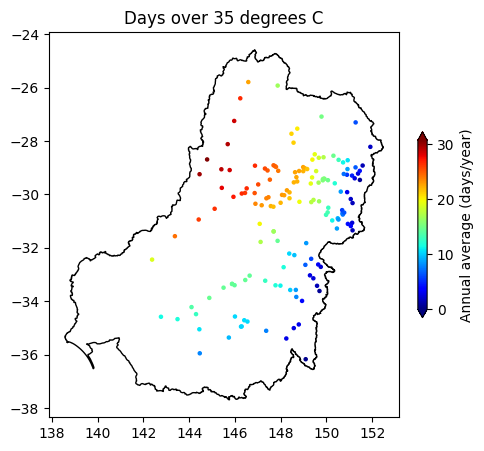

In [178]:
fig, axs = plt.subplots(1,1,figsize=(6,5) ,squeeze=False)

plti = 0
maxscale = usetemp['days_above_35'].max()
minscale = usetemp['days_above_35'].min()
nbounds = max(4,int(np.ceil( maxscale)))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))
usebounds  = [0, maxscale]
ncolors = len(bounds) - 1


            
cmap = plt.get_cmap('jet') #, ncolors)
#norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)
norm = mpl.colors.Normalize(usebounds[0], usebounds[1], clip = True)


mdbboundary.plot(color = 'None', ax = axs[0,plti])

sc = axs[0,plti].scatter(x = usetemp['lon'], y = usetemp['lat'], c =usetemp['days_above_35'], norm = norm,cmap = cmap, s = 5)
axs[0,plti].set_title(f'Days over 35 degrees C')
            #fig.colorbar(sc,ax=axs[0,plti],orientation='vertical', fraction=0.02, pad=0.04)
figtitle = "Annual average (days/year)"
fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = figtitle, extend = 'both')
fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'station_temps.png')
fig.savefig(fig_path,bbox_inches='tight')


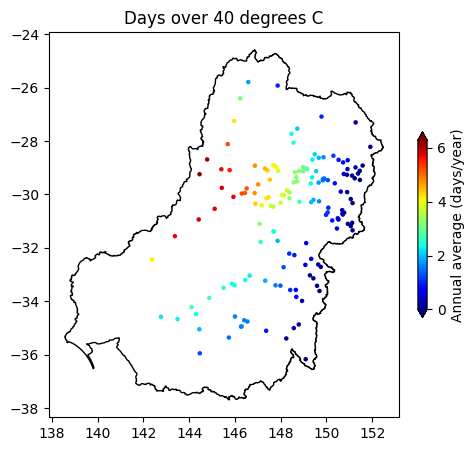

In [179]:
fig, axs = plt.subplots(1,1,figsize=(6,5) ,squeeze=False)

plti = 0
maxscale = usetemp['days_above_40'].max()
minscale = usetemp['days_above_40'].min()
nbounds = max(4,int(np.ceil( maxscale)))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))
usebounds  = [0, maxscale]
ncolors = len(bounds) - 1


            
cmap = plt.get_cmap('jet') #, ncolors)
#norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)
norm = mpl.colors.Normalize(usebounds[0], usebounds[1], clip = True)


mdbboundary.plot(color = 'None', ax = axs[0,plti])

sc = axs[0,plti].scatter(x = usetemp['lon'], y = usetemp['lat'], c =usetemp['days_above_40'], norm = norm,cmap = cmap, s = 5)
axs[0,plti].set_title(f'Days over 40 degrees C')
            #fig.colorbar(sc,ax=axs[0,plti],orientation='vertical', fraction=0.02, pad=0.04)
figtitle = "Annual average (days/year)"
fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = figtitle, extend = 'both')
# fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'station_temps.png')
# fig.savefig(fig_path,bbox_inches='tight')


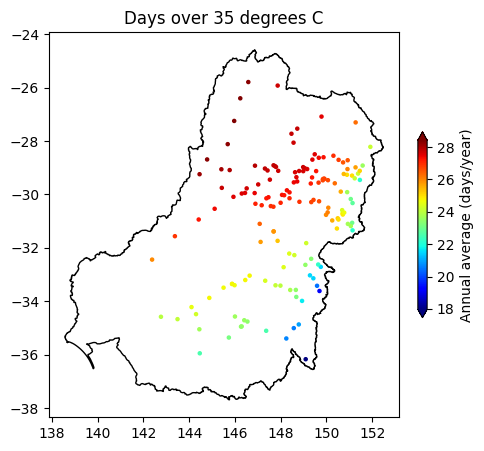

In [180]:
fig, axs = plt.subplots(1,1,figsize=(6,5) ,squeeze=False)

plti = 0
maxscale = usetemp['mean_max'].max()
minscale = usetemp['mean_max'].min()
nbounds = max(4,int(np.ceil( maxscale)))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))
usebounds  = [minscale, maxscale]
ncolors = len(bounds) - 1


            
cmap = plt.get_cmap('jet') #, ncolors)
#norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)
norm = mpl.colors.Normalize(usebounds[0], usebounds[1], clip = True)


mdbboundary.plot(color = 'None', ax = axs[0,plti])

sc = axs[0,plti].scatter(x = usetemp['lon'], y = usetemp['lat'], c =usetemp['mean_max'], norm = norm,cmap = cmap, s = 5)
axs[0,plti].set_title(f'Days over 35 degrees C')
            #fig.colorbar(sc,ax=axs[0,plti],orientation='vertical', fraction=0.02, pad=0.04)
figtitle = "Annual average (days/year)"
fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = figtitle, extend = 'both')
fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'station_temps_mean.png')
fig.savefig(fig_path,bbox_inches='tight')
